Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/sysid.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='975f925803f947c5bacf4dd28b7aa880c77c2039', drake_version='0.27.0', drake_build='release')

import numpy as np
import matplotlib.pyplot as plt

import pydrake.all
from pydrake.all import (
    LinearSystem,
    DiagramBuilder, PiecewisePolynomial, TrajectorySource,
    LogOutput, Simulator, LinearQuadraticRegulator
)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve


Cloning into '/opt/underactuated'...

HEAD is now at 975f925 add linear_sysid exercise (#443)






# Linear System Identification

In this notebook, you will test different objective functions in linear system identification. Consider a discrete-time linear system of the form

$$x[n+1] = Ax[n]+Bu[n]$$
where $x[n]\in\mathbf{R}^p$ and $u[n]\in\mathbf{R}^q$ are state and control at step $n$.
The system matrix $A\in\mathbf{R}^{p\times p}$ and $B\in\mathbf{R}^{p\times q}$ are unknown parameters of the model, and your task is to identify the parameters given a simulated trajectory.

Let's first define a test system:

In [2]:
A = np.array([[0.8, -0.1, 0.0, 0.0], 
              [0., 0.2, 0.0, 0.1], 
              [0., -0.1, 1.0001, 0.0], 
              [0., 0.2, 0.0, 0.1]])

B = np.array([[0.0], [-0.02], [0.01], [-0.02]])
C = np.identity(4)
D = np.zeros((4,1))

Let's run a simulation to obtain the trajectory data. We add noise to the state representing measurement noise.

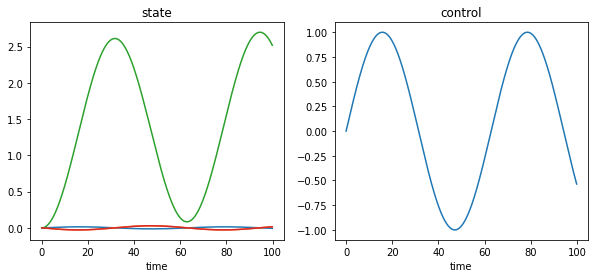

In [3]:
def generate_data(A, B, C, D, noise_level = 1e-5):
    # Define a Linear system
    sys = LinearSystem(A, B, C, D, time_period = 0.1)

    ts = np.arange(0, 100, 0.1)
    utraj = PiecewisePolynomial.CubicShapePreserving(ts, np.sin(0.1*ts).reshape((1,-1)))

    builder = DiagramBuilder()
    plant = builder.AddSystem(sys)

    usys = builder.AddSystem(TrajectorySource(utraj)) 
    builder.Connect(usys.get_output_port(), plant.get_input_port())

    logger = LogOutput(plant.get_output_port(), builder)
    diagram = builder.Build()

    simulator = Simulator(diagram)
    simulator.AdvanceTo(ts[-1])

    t = logger.sample_times()
    U = utraj.vector_values(logger.sample_times())
    X = logger.data()
    X = X + np.random.normal(size = X.shape)*noise_level

    return t, U, X
        

t, U, X = generate_data(A, B, C, D)


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(t, X.T)
ax[1].plot(t, U.T)
ax[0].set_title("state")
ax[1].set_title("control")
ax[0].set_xlabel("time")
ax[1].set_xlabel("time")
plt.show()

The output of the simulation gives the data matrices in the following format:

$$X=\begin{bmatrix} \lvert && \lvert && && \lvert \\ x[0] && x[1] && \dots && x[N] \\ \lvert && \lvert && && \lvert \end{bmatrix}$$


$$U=\begin{bmatrix} \lvert && \lvert && && \lvert \\ u[0] && u[1] && \dots && u[N] \\ \lvert && \lvert && && \lvert \end{bmatrix}.$$

Using the simulated data, you will implement regression algorithms to identify the system model.

(a) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_2^2$$

The function should output the matrices $A$ and $B$ that are the solutions to the above optimization problem.

In [4]:
def sysid_2norm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))
    
    ######### Put your Solution here ############
    
    prog = MathematicalProgram()
    
    # Create the optimization variables
    A_opt = prog.NewContinuousVariables(n, n, "A_opt")
    B_opt = prog.NewContinuousVariables(n, m, "B_opt")
    
    # Loop over all the time steps and add the equation error
    N = X.shape[1]

    for n in range(N-1):
        # Loop over all but the last time step
        x_n = X[:,n].reshape((-1,1))
        u_n = U[:,n].reshape((-1,1))
        x_nPlus1 = X[:,n+1].reshape((-1,1))

        # Add this quadratic cost contribution
        prog.AddQuadraticCost( (x_nPlus1 - A_opt.dot(x_n) - B_opt.dot(u_n)).T.dot(x_nPlus1 - A_opt.dot(x_n) - B_opt.dot(u_n))[0,0] )
        

    result = Solve(prog)
    obj_value = result.get_optimal_cost()
    
    A = result.GetSolution(A_opt)
    B = result.GetSolution(B_opt).reshape((-1,1))

    ##############################################
    
    return A, B

Ahat_2norm, Bhat_2norm = sysid_2norm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_2norm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_2norm)
print("")

res = Ahat_2norm @ X[:,:-1] + Bhat_2norm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.50894289e-01 -1.30709179e-01  9.14455324e-08 -7.80597484e-02]
 [-1.55801768e-02  1.57810806e-01  5.31155743e-08  1.08317293e-01]
 [ 6.23049434e-03 -7.63577519e-02  1.00010000e+00 -9.69254297e-03]
 [-2.58619099e-02  1.50449781e-01  1.83133458e-07  9.24043291e-02]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.00240788]
 [-0.02074546]
 [ 0.0103098 ]
 [-0.02126429]]

residual (2-norm): 5.649444844818659e-07
residual (inf-norm): 0.01744300241118628
residual (1-norm): 0.03756163459976535


(b) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_{\infty}.$$

where $L\infty$ norm of a vector is defined as

$$\lVert x \rVert_\infty = \max_{1\leq i\leq p}\lvert x_i\rvert.$$
Implement the following function that outputs the matrices $A$ and $B$ that are the solutions to the above optimization problem.


In [5]:
def sysid_infnorm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))
    
    ######### Put your Solution here ############

    # We transform the L_infinity norm problem into a linear program to be solved

    prog = MathematicalProgram()

    # Create the optimization variables
    A_opt = prog.NewContinuousVariables(n, n, "A_opt")
    B_opt = prog.NewContinuousVariables(n, m, "B_opt")
    
    N = X.shape[1]  # Number of time steps of data

    # The L_infinity norm additional variables (we use one less
    # time step of data)
    t_opt = prog.NewContinuousVariables(N-1, "t_opt")

    for k in range(N-1):
        # Loop over the time steps

        x_k = X[:,k].reshape((-1,1))
        u_k = U[:,k].reshape((-1,1))
        x_kPlus1 = X[:,k+1].reshape((-1,1))

        # Get the equation error for this step
        eqn_error_k = x_kPlus1 - A_opt.dot(x_k) - B_opt.dot(u_k)

        # Add the linear cost
        prog.AddLinearCost(t_opt[k])

        # Add the linear inequality constraints
        for i in range(n):
            prog.AddLinearConstraint(eqn_error_k[i,0] <= t_opt[k])
            prog.AddLinearConstraint(-eqn_error_k[i,0] <= t_opt[k])

    result = Solve(prog)
    obj_value = result.get_optimal_cost()

    A = result.GetSolution(A_opt)
    B = result.GetSolution(B_opt).reshape((-1,1))

    ##############################################

    return A, B, obj_value

Ahat_infnorm, Bhat_infnorm, obj_infnorm = sysid_infnorm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_infnorm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_infnorm)
print("")

res = Ahat_infnorm @ X[:,:-1] + Bhat_infnorm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.10517098e-01 -1.61977079e-01 -1.39488096e-07 -1.36670543e-01]
 [-4.01339167e-02  9.49105438e-02 -1.18314633e-08  1.17665633e-01]
 [ 4.52705450e-02 -1.98170348e-02  1.00010004e+00  2.37805758e-02]
 [-2.69634430e-02  1.58016717e-01  2.96967645e-07  8.22120043e-02]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.00440027]
 [-0.02192573]
 [ 0.01232544]
 [-0.02132459]]

residual (2-norm): 5.726520018607925e-07
residual (inf-norm): 0.017389491837741355
residual (1-norm): 0.03771602466127823


(c) Identify the model by solving the following optimization problem: 

$$\min_{A, B}\sum_{n=0}^{N-1}\lVert x[n+1] - Ax[n] -Bu[n] \rVert_1.$$
where the $L1$ norm of a vector is defined as
$$\lVert x \rVert_1 = \sum_{i=1}^p \lvert x_i\rvert.$$
The function should output the matrices $A$ and $B$ that are the solutions to the above optimization problem.


In [6]:
def sysid_1norm(X, U):
    n = X.shape[0]
    m = U.shape[0]
    A = np.zeros((n,n))
    B = np.zeros((n,m))

    ######### Put your Solution here ############

    # We transform the L1 optimization problem into a linear program
    prog = MathematicalProgram()

    A_opt = prog.NewContinuousVariables(n, n, "A_opt")
    B_opt = prog.NewContinuousVariables(n, m, "B_opt")
    
    N = X.shape[1]  # Number of time steps of data

    # Slack variables
    t_opt = prog.NewContinuousVariables(N-1, n, "t_opt")

    for k in range(N-1):
        # Loop over the time steps

        x_k = X[:,k].reshape((-1,1))
        u_k = U[:,k].reshape((-1,1))
        x_kPlus1 = X[:,k+1].reshape((-1,1))

        # Get the equation error for this step
        eqn_error_k = x_kPlus1 - A_opt.dot(x_k) - B_opt.dot(u_k)

        # Add the linear cost + slack variables for each term in eqn_error_k
        # expanded using the L1 norm

        for i in range(n):
            # Linaer cost term
            prog.AddLinearCost(t_opt[k, i])

            # Linear inequality constraints
            prog.AddLinearConstraint(eqn_error_k[i,0] <= t_opt[k, i])
            prog.AddLinearConstraint(-eqn_error_k[i,0] <= t_opt[k, i])


    result = Solve(prog)
    obj_value = result.get_optimal_cost()

    A = result.GetSolution(A_opt)
    B = result.GetSolution(B_opt).reshape((-1,1))

    ##############################################
    return A, B, obj_value

Ahat_1norm, Bhat_1norm, obj_1norm = sysid_1norm(X, U)

print("A = ")
print(A)
print("Â = ")
print(Ahat_1norm)
print("")
print("B = ")
print(B)
print("B̂ = ")
print(Bhat_1norm)
print("")

res = Ahat_1norm @ X[:,:-1] + Bhat_1norm @ U[:,:-1] - X[:,1:]
print(f'residual (2-norm): {np.sum(res**2)}')
print(f'residual (inf-norm): {np.sum(np.max(np.abs(res), axis = 0))}')
print(f'residual (1-norm): {np.sum(np.abs(res))}')

A = 
[[ 0.8    -0.1     0.      0.    ]
 [ 0.      0.2     0.      0.1   ]
 [ 0.     -0.1     1.0001  0.    ]
 [ 0.      0.2     0.      0.1   ]]
Â = 
[[ 7.09508973e-01 -2.01707629e-01  6.69076865e-07 -9.66822311e-02]
 [-3.57198891e-02  1.41048710e-01  1.35775982e-07  7.94538419e-02]
 [-5.44877390e-03 -1.07436650e-01  1.00009980e+00 -3.39734164e-03]
 [-2.88790980e-02  1.31311604e-01 -2.17061964e-07  1.04553337e-01]]

B = 
[[ 0.  ]
 [-0.02]
 [ 0.01]
 [-0.02]]
B̂ = 
[[-0.00437861]
 [-0.02176161]
 [ 0.00976769]
 [-0.02142048]]

residual (2-norm): 5.70208400482061e-07
residual (inf-norm): 0.017476074620300847
residual (1-norm): 0.037480535035774754


Let's try LQR controller with the identified models. Using the estimated parameters, $\hat{A}$ and $\hat{B}$, we solve discrete-time LQR. The controller is used to stabilize the original linear system defined by the parameters, $A$ and $B$. If the estimate was accurate, we expect the controller to work well for the original system.

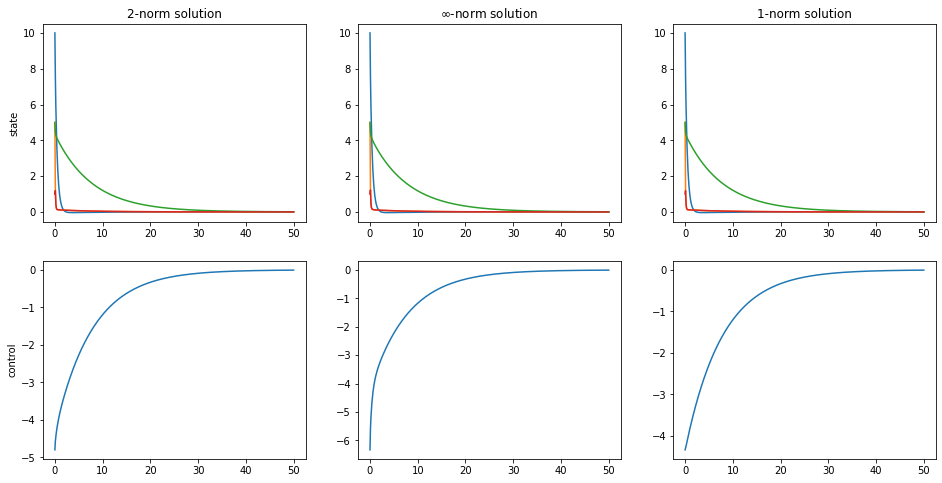

In [7]:

def test_LQR(A_hat, B_hat, Q = None, R = None):
  Q = np.identity(A.shape[0]) if Q is None else Q
  R = np.identity(B.shape[1]) if R is None else R
  
  # Define a Linear system
  sys = LinearSystem(A, B, C, D, time_period = 0.1)
  sys_hat = LinearSystem(A_hat, B_hat, C, D, time_period = 0.1)

  builder = DiagramBuilder()
  plant = builder.AddSystem(sys)

  controller = builder.AddSystem(LinearQuadraticRegulator(sys_hat, Q, R))

  builder.Connect(controller.get_output_port(), plant.get_input_port())
  builder.Connect(plant.get_output_port(), controller.get_input_port())

  logger = LogOutput(plant.get_output_port(), builder)
  log_ctrl = LogOutput(controller.get_output_port(), builder)

  diagram = builder.Build()
  simulator = Simulator(diagram)
  context = simulator.get_mutable_context()
  context.SetDiscreteState(0,[10.,5.,5.,1.])

  simulator.AdvanceTo(50)

  t = logger.sample_times()
  U = log_ctrl.data()
  X = logger.data()

  return t, U, X

t, U_2norm, X_2norm = test_LQR(Ahat_2norm, Bhat_2norm)
t, U_infnorm, X_infnorm = test_LQR(Ahat_infnorm, Bhat_infnorm)
t, U_1norm, X_1norm = test_LQR(Ahat_1norm, Bhat_1norm)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0,0].plot(t, X_2norm.T)
ax[1,0].plot(t, U_2norm.T)
ax[0,1].plot(t, X_infnorm.T)
ax[1,1].plot(t, U_infnorm.T)
ax[0,2].plot(t, X_1norm.T)
ax[1,2].plot(t, U_1norm.T)
ax[0,0].set_ylabel("state")
ax[1,0].set_ylabel("control")
ax[0,0].set_title("2-norm solution")
ax[0,1].set_title("$\infty$-norm solution")
ax[0,2].set_title("1-norm solution")
plt.show()


You can also test the model with increased noise in the data. You can play around with different values of 'noise_level' to vary the intensity of the noise in the measurement.

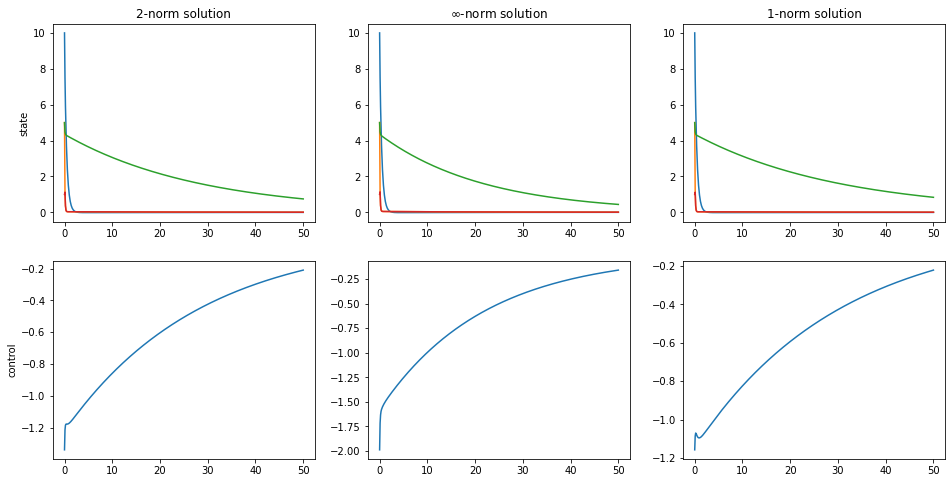

In [8]:
t, U_noisy, X_noisy = generate_data(A, B, C, D, noise_level = 0.5)

Ahat_noisy_2norm, Bhat_noisy_2norm = sysid_2norm(X_noisy, U_noisy)
t, U_2norm, X_2norm = test_LQR(Ahat_noisy_2norm, Bhat_noisy_2norm)

Ahat_noisy_infnorm, Bhat_noisy_infnorm, obj_infnorm_noisy = sysid_infnorm(X_noisy, U_noisy)
t, U_infnorm, X_infnorm = test_LQR(Ahat_noisy_infnorm, Bhat_noisy_infnorm)

Ahat_noisy_1norm, Bhat_noisy_1norm, obj_1norm_noisy = sysid_1norm(X_noisy, U_noisy)
t, U_1norm, X_1norm = test_LQR(Ahat_noisy_1norm, Bhat_noisy_1norm)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0,0].plot(t, X_2norm.T)
ax[1,0].plot(t, U_2norm.T)
ax[0,1].plot(t, X_infnorm.T)
ax[1,1].plot(t, U_infnorm.T)
ax[0,2].plot(t, X_1norm.T)
ax[1,2].plot(t, U_1norm.T)
ax[0,0].set_ylabel("state")
ax[1,0].set_ylabel("control")
ax[0,0].set_title("2-norm solution")
ax[0,1].set_title("$\infty$-norm solution")
ax[0,2].set_title("1-norm solution")
plt.show()


## Autograding
You can check your work by running the following cell:

In [9]:
from underactuated.exercises.sysid.linear_sysid.test_linear_sysid import TestLinearSysid
from underactuated.exercises.grader import Grader
Grader.grade_output([TestLinearSysid], [locals()], 'results.json')
Grader.print_test_results('results.json')


Total score is 9/9.

Score for Test L1 regression is 3/3.

Score for Test L2 regression is 3/3.

Score for Test L infinite regression is 3/3.
